In [2]:
import powerplantmatching as pm
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import expon
from scipy.optimize import curve_fit
from astropy.visualization import hist
#for fitting:
from scipy.stats import expon, rv_discrete
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#for plotting Markov Chain graph
import networkx as nx
import matplotlib.pyplot as plt


#helper functions

def import_df(path, cols = ['StartTS', 'EndTS', 'TimeZone', 'Status', 'Type', 'AreaCode',
       'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName',
       'ProductionType', 'InstalledCapacity', 'AvailableCapacity',
       'Reason']):
    """
    imports and preprocess data_frame
    path: string containing path of csv file containing table
    cols: list of column names to select in df
    returns: non redundat dataframe with only failures
    """
    
    df = pd.read_csv(path, sep = "\t", parse_dates = [0,1])
    df = df[cols] #selects only column
    df = df.drop_duplicates(subset = ["UnitName","StartTS"]) #deletes redundant rows
    #df = df[(df["Reason"] == "Failure")] # WHERE | (df["Reason"] == 'Foreseen Maintenance')
    #maybe can do df[df["Reason"] in reasons]?
    return df

def get_week(date):
    """
    input: date in date_time format
    output: what week of the year the date corresponds to
    """
    return date.week


def truncate(number, digits) -> float:
    # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
    nbDecimals = len(str(number).split('.')[1]) 
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def markov_graph(transitions, seed = 42, digits = 4, title = ""):
    """
    input: transitions, a dictionary having as 
    keys: touples with 2 elements being the from state and from state
    values: the transition probability
    output: markov chain graph
    """
    G = nx.MultiDiGraph()

    for transition, probability in transitions.items():
        state_from, state_to = transition
        if probability != 0: 
        #if probability state_from to state_to is not 0 we add an edge to the graph
            G.add_edge(state_from, state_to, weight=truncate(probability, digits))

    #create positions of nodes: dictionary with coordinates
    pos = nx.spring_layout(G, seed) 

    # Increase the scale to avoid overlap
    pos = {k: [v[0] * 2, v[1] * 2] for k, v in pos.items()}

    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black',
            connectionstyle='arc3,rad=0.1')

    # Annotate edges manually with adjusted positions to avoid overlap
    for edge, weight in labels.items():
        (x, y) = pos[edge[0]]
        text_x = 3/4*x + 1/4*pos[edge[1]][0]
        text_y = 3/4*y + 1/4*pos[edge[1]][1]
        #shift text to avoid overlap
        text_y += 0.2 if edge[0] == edge[1] else 0


        plt.text(text_x, text_y, f"{weight}", fontsize=8, color='blue', verticalalignment='center',
                 horizontalalignment='center')
    plt.title(title)
    plt.show()
    
    
def combine_overlaps(df):
    """
    this functions combines any time overlaps present in the dataframe for each generator
    so that for every time t there is at most one row describing the generator at time t.
    df: dataframe containing UnitName, StartTS, EndTS
    """

    # Step 1: Sort the DataFrame
    df.sort_values(by=["UnitName", "StartTS"], inplace=True)

    # Step 2 and 3: Combine overlapping intervals
    result = []
    current_interval = None
    n_rows = df.shape[0]
    perc = n_rows // 100 *  5

    for k, row in df.iterrows():
        if k % perc == 0:
            print(f"percentage of rows parsed = {k / n_rows *100:.2f}%")
        if current_interval is None:
             current_interval = row.copy()
        elif row["StartTS"] >= current_interval["EndTS"] or row["UnitName"] != current_interval["UnitName"]:
            # No overlap or new UnitID
            result.append(current_interval)
            current_interval = row.copy()
        else:
            # Overlapping intervals, update the EndTS
            current_interval["EndTS"] = row["StartTS"]

    result_df = pd.DataFrame(result)

    return result_df


def get_markov_probs(df, states_column):
    """
    input:
    df: dataframe having as columns: states_column, "ProductionType", "StartTS", "UpTime"
    states_column: string with name of column where the state of the generator is saved
    output: dictionary having as keys tuples with two states and the associated probability transition
    """
    states = list(df[states_column].unique())
    states.append("Running")
    transitions = []
    for x in states:
        for y in states:
            transitions.append((x,y))
            
    transitions_counter = dict(zip(transitions, [0]*len(transitions)))
    GenGroups = df.groupby("UnitName")
    previous_state = "Running"
    current_state = "Running"
    for unit_name, unit_df in GenGroups:
        unit_df = unit_df.sort_values(["StartTS"])
        #count transition occurante for unit
        for index, row in unit_df.iterrows():
            uptime = row["RunningTime"]
            #get current state from row
            current_state = row[states_column]

            if pd.isna(uptime):
                #if uptime == "Nan" then it was the first recorded instance of the generator in the dataframe so before it was running.
                previous_state = "Running"
            elif uptime > 10 / (60 * 24): # and previous_state != "Running"
                #if the generator had some time between the previous row than the previous state was running
                #and we must add 1 to previousprevious state and running
                transitions_counter[(previous_state, "Running")] += 1
                previous_state = "Running"    

            transitions_counter[(previous_state, current_state)] += 1
            #the current state becomes the previous_state
            previous_state = current_state

    #get the transtions probabilities
    transitions_probs = transitions_counter
    counter_dict = dict(zip(states, [0]*len(states)))
    for state in states:
        for transition, counter in transitions_probs.items():
            if transition[0] == state:
                counter_dict[state] += counter 

    for transition, counter in transitions_probs.items():
        if counter_dict[transition[0]] != 0:
            #if transition[0] occurs at least one time
            transitions_probs[transition] = transitions_probs[transition] / counter_dict[transition[0]]
    return transitions_probs

def weighted_values(values, probabilities, size):
    bins = np.add.accumulate(probabilities)
    return values[np.digitize(np.random.random_sample(size), bins)]

def next_state_markov(markov, current_state):
    possible_states = []
    transition_probs = []
    for key, prob in markov.items():
        if key[0] == current_state and prob != 0:
            possible_states.append(key[1])
            transition_probs.append(prob)
    #if len(possible_states) == 0:
    #    return current_state
    #else:
    return weighted_values(np.array(possible_states), np.array(transition_probs),1)[0]

def get_gen_type(geo_df):
    geo_to_entsoe_gen_d = {
        "Hard Coal": "Fossil Hard coal ", 
        'Lignite' : 'Fossil Brown coal/Lignite ',
        'Oil': "Fossil Oil ",
        'Waste': "Waste ",
        'Natural Gas': "Fossil Gas ",#o ci andrebbe qualcos altro
        #'Hydro',
        'Nuclear': "Nuclear ", 
        'Other' : "Other ", 
        'Solar':"Solar ",
        'Wind':"Wind Onshore ",
        'Geothermal':"Geothermal "
        }
    #given a unit row of geo dataframe give gen type in ENTSOE format
    #in geo there is just one windpower type (not onshore or offshore) or maybe you can see from the dataframe
    fuel_type = geo_df["Fueltype"]
    gen_type = geo_df["Technology"]
    if fuel_type == "Hydro":
        if gen_type == "Reservoir":
            return 'Hydro Water Reservoir '
        elif gen_type == "Run-Of-River":
            return 'Hydro Run-of-river and poundage '
        elif gen_type == "Pumped Storage":
            return 'Hydro Pumped Storage '
    elif fuel_type in geo_to_entsoe_gen_d.keys():
        return geo_to_entsoe_gen_d[fuel_type]
    else:
        print(f"Generetor {gen_type},{fuel_type} not found classfied as Other")
        return "Other "



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Questions:
1. There is no onshore / offshore windpower ---> remove them
2. What is Hydro without further specification 
3. For what timeframe should I generate data?
4. Solar ----> remove them

# TODO:
- ~remove redundant gens in geo~
- ~add seed for random variables~

In [3]:
#Set parameters
geo = pm.data.GEO()
geo = geo.groupby("projectID").head(1)

start_time = np.datetime64("2023-01-01T00:00:00")
end_time = np.datetime64("2023-06-01T00:00:00")
seed = 2193 #set for replicable scenario generation
#import distribution parameters

## Dataset descripiton

    - projectID - Immutable identifier of the power plant
        
    - Power plant name - claim of each database

    - Fueltype - {Bioenergy, Geothermal, Hard Coal, Hydro, Lignite, Nuclear, Natural Gas, Oil, Solar, Wind, Other}

    - Technology - {CCGT, OCGT, Steam Turbine, Combustion Engine, Run-Of-River, Pumped Storage, Reservoir}

    - Set - {Power Plant (PP), Combined Heat and Power (CHP), Storages (Stores)}

    - Capacity - [MW]

    - Duration - Maximum state of charge capacity in terms of hours at full output capacity

    - Dam Information - Dam volume [Mm^3] and Dam Height [m]

    - Geo-position - Latitude, Longitude

    - Country - EU-27 + CH + NO (+ UK) minus Cyprus and Malta

    - YearCommissioned - Commmisioning year of the powerplant

    - RetroFit - Year of last retrofit




In [4]:
#Import Outages Dataframe to construct model ENTSO-E format
data_path = "../outagesmodelingdata/"
df = pd.read_csv(data_path+"deltaWithEverything_df.csv", parse_dates = [0,1])
df["StartTS"] = pd.to_datetime(df["StartTS"])
df["EndTS"] = pd.to_datetime(df["EndTS"])
df = df.sort_values(["UnitName","StartTS"])

#Combine overlaps fo that every generator is only at one state at the time
df = combine_overlaps(df)
#combine countries
df["MapCode"] = df["MapCode"].apply(lambda x: x[0:2])


percentage of rows parsed = 0.00%
percentage of rows parsed = 5.00%
percentage of rows parsed = 10.00%
percentage of rows parsed = 15.00%
percentage of rows parsed = 20.00%
percentage of rows parsed = 25.00%
percentage of rows parsed = 30.00%
percentage of rows parsed = 35.00%
percentage of rows parsed = 39.99%
percentage of rows parsed = 44.99%
percentage of rows parsed = 49.99%
percentage of rows parsed = 54.99%
percentage of rows parsed = 59.99%
percentage of rows parsed = 64.99%
percentage of rows parsed = 69.99%
percentage of rows parsed = 74.99%
percentage of rows parsed = 79.99%
percentage of rows parsed = 84.99%
percentage of rows parsed = 89.99%
percentage of rows parsed = 94.99%
percentage of rows parsed = 99.99%


In [5]:
#Create model
#statetime_df: dataframe with the parametres of the exponantialdistribution of statetime
#markov_d: dictionary of markov chains of the various generator types
#capacity_d: dictionary of distributions of capacity in p.u.
#STATE TIME MODELING

#In this section we model the time a generator spends in a certain state. We model the random variable time in each state with a exponential distribution using the maximum likelyhood estimator (MLE).

#Change state_column to look ad different state distributions
state_column = "Type"

#def state_time_distribution_fitting(df, state_column):

states = list(df[state_column].unique())
delta_df = df
delta_df = delta_df.sort_values(by = ["UnitName", "StartTS"])

for state in states:
    #calculate time spend in each state
    delta_df[state+"Time"] = [np.datetime64("NaT")]*df.shape[0]
    state_df = delta_df[delta_df[state_column] == state]
    delta_df.loc[delta_df[state_column] == state, state+"Time"] = state_df["EndTS"] - state_df["StartTS"]
    delta_df[state+"Time"] = (delta_df[state+"Time"] /  np.timedelta64(1, 'h'))
    
for unit, unit_df in delta_df.groupby("UnitName"):                             
    unit_df["EndTS"] = pd.to_datetime(unit_df["EndTS"])
    shifted_endts = pd.to_datetime(unit_df["EndTS"].shift())
    start_ts = delta_df.loc[delta_df["UnitName"] == unit, "StartTS"]
    delta_df.loc[delta_df["UnitName"] == unit, "RunningTime"] = start_ts - shifted_endts

delta_df["RunningTime"] = (delta_df["RunningTime"] /  np.timedelta64(1, 'h'))
delta_df.loc[delta_df["RunningTime"] == 0, "RunningTime"] = np.nan

states = states + ["Running"]


#fit outages distributions
statetime_df = pd.DataFrame() #create empty parameter table
grouped_delta = delta_df.groupby(["ProductionType"])
statetime_df["ProductionType"] = grouped_delta.first().reset_index()["ProductionType"]
for state in states:
    statetime_df[state + "Time"] = [np.nan]*len(list(statetime_df["ProductionType"]))


def exponential_fit(x, scale):
    return expon.pdf(x, scale=scale)


for group_name, group_df in grouped_delta:
    
    #We drop NaN valued rows
    #group_df = group_df.dropna(subset = ["UpTime","OffTime"])
    
    for state in states:
        if not pd.isna(group_df[state+"Time"].mean()):
            # Fit the data to the exponential function
            mean = group_df[state+"Time"].mean()
            state_scale = mean
            statetime_df.loc[statetime_df["ProductionType"] == group_name[0], state+"Time"] = state_scale
            #plt.figure() #uncomment to plot
            #plt.xlim(0, 3*mean)  # Adjust the values as needed
            #plt.ylim(0, 1)  # Adjust the values as needed
            #plt.hist(group_df[state + "Time"], bins=5000, edgecolor='black', density=True)
            # Plot the fitted exponential distribution
            #x = np.sort(group_df[state + "Time"])
            #plt.plot(x, exponential_fit(x, scale = state_scale), 'r-', label='Exponential Fit')
            #plt.xlabel(f'Duration {state + "Time"}')
            #plt.ylabel('Frequency')
            #plt.title(f'{state}Time {group_name}')
            #plt.legend()
            #plt.show()


            
#MARKOV CHAIN MODELING
print("Starting Markov chain modeling")
df = delta_df[delta_df["Reason"] != "Shutdown" ] #remove shutdowns 

markov_d= {}
#Create a list containing tuples rapresenting all possible state changes (x,y) := x --> y
#data is a dataframe containing the correct "UpTime" between the states considered

GenTypeGroup_df = df.groupby("ProductionType")

#We can use different states
#print markov chain for each type of generator
for production_type, data in GenTypeGroup_df:
    transitions_probs = get_markov_probs(data, "Type")
    markov_d[production_type] = transitions_probs
    #uncomment to plot:
    #markov_graph(transitions_probs, title = f"{production_type} Markov Chain")

#t_probs = dict(transitions_probs)
#for key, value in transitions_probs.items():
#    if value < 0.05:
#        del t_probs[key]
#print graph


#CAPACITY MODELING
print("Starting Capacity Modeling")
#With Kernel density estimation
grouped_df = df.groupby(["ProductionType", "Type"])
capacity_d = {}
#idea: calculate prob for capacity = 0, remove and the use non parametric fit.
for production_type, prod_df in grouped_df:
    #calculate per unit available capacity
    PU = prod_df["AvailableCapacity"].copy() / prod_df["InstalledCapacity"]
    df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU
    PU = PU[~np.isnan(PU)]
    p_0 = np.sum(PU == 0) / len(PU)
    PUplus = np.sort(PU[PU != 0]) #non zero capacities
    if len(PUplus) != 0:
        
        colors = ["r"]
        kernels = ["gaussian"]
        lw = 2
        #Uncomment to plot
        
        #plt.figure()
        for color, kernel in zip(colors, kernels):
            kde = KernelDensity(kernel=kernel, bandwidth=0.05).fit(PUplus[:, np.newaxis])
            capacity_d[production_type] = (p_0, kde)
            log_dens = kde.score_samples(PUplus[:, np.newaxis]) * len(PUplus) / len(PU) #scale to be prob on non zero values
            Y = np.exp(log_dens)
            #plt.plot(PUplus, Y, color = color, label = kernel)
            
        """
        # Plot histogram

        plt.xlim(0, 1)
        
        plt.hist(PU, bins=min(500, int(np.ceil(len(PU) ** (1. / 3))*3/2)) + 3 , edgecolor='black', alpha=0.7, density = True)

        # Customize the plot (add labels, title, etc.)
        plt.xlabel('p.u. Available Capacity')
        plt.ylabel('Frequency')
        plt.title(f'{production_type}')
        plt.legend()
        plt.show()
        """


Starting Markov chain modeling
Starting Capacity Modeling


/tmp/ipykernel_31388/416507078.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df["ProductionType"] == production_type[0]) & (df["Type"] == production_type[1]), "p.u."] = PU


In [6]:
geo_gen_types = geo["Technology"].unique()
geo_fuel_types = geo["Fueltype"].unique()
grouped  = df.groupby(["UnitName"]).first().reset_index()
entsoe_gen_types = list(grouped["ProductionType"].unique())

In [7]:
# Generating Scenarios

#Starting state --> we roll random running time for every generator the end
# todo: make the markov chaing run for a while to make the various generators get further in states
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
np.random.seed(seed)
grouped  = df.groupby(["UnitName"]).first().reset_index()
gen_names = list(geo["projectID"])
gen_types = []
for index, geo_row in geo.iterrows():
    gen_type = get_gen_type(geo_row)
    if gen_type is None:
        tech = geo_row["Technology"]
        fuel = geo_row["Fueltype"]
        print("Weird thing:", tech, fuel)
        gen_types.append("Other ")
    else:
        gen_types.append(gen_type)

n_gens = len(gen_names)
pre_run_hours = 6*30*24 #time the chain is run for before producing data

states = ["Running", "Forced", "Planned"]
state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})
perc = np.ceil(pre_run_hours / 100)

for h in np.arange(pre_run_hours):
    
    if h % (perc) == 0:
        print(f"{h/pre_run_hours *100} %")
        print(state_df.head(5))
    
    for index, gen_row in state_df[state_df["Counter"] == 0].iterrows():
        gen_name = gen_row["UnitName"] #remove?
        gen_type = gen_row["ProductionType"]
        current_state = gen_row["State"]
        markov = markov_d[gen_type] #get associate markov chain
        
        new_state = next_state_markov(markov, current_state) #get new state of the generator
        
        scale = statetime_df.loc[statetime_df["ProductionType"] == gen_type, new_state + "Time"]
        new_counter = np.ceil(np.random.exponential(scale, 1))[0] #get number of hours spent in new_state
        
        #get the capacity of the generator in the currnent state
        if new_state == "Running":
            new_capacity = 1
        elif (gen_type, new_state) in capacity_d.keys():
            p_zero, pu_pdf = capacity_d[(gen_type, new_state)]
            if np.random.random_sample(1)[0] <= p_zero:
                new_capacity = 0
            else:
                new_capacity = pu_pdf.sample(1)[0][0]
                if new_capacity < 0:
                    new_capacity = 0
                elif new_capacity > 1:
                    new_capacity = 1
        else:
            #todo this should not happen
            #print(f"no capacity distribution for {gen_type}")
            new_capacity = 1
        
        state_df.loc[index, ["State", "Counter", "Capacity"]] = [new_state, new_counter, new_capacity]
        
    state_df.loc[state_df["Counter"] != 0, "Counter"] -= 1
    
#idea: 
# while t < 10 years roll dices take final state and final counter

Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing: nan Hydro
Weird thing

17.314814814814813 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running       88       1.0
1  GEO-45150  Fossil Hard coal   Running      190       1.0
2  GEO-45719  Fossil Hard coal   Running       65       1.0
3  GEO-41956  Fossil Hard coal   Running      187       1.0
4  GEO-41974  Fossil Hard coal   Running      103       1.0
18.333333333333332 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running       44       1.0
1  GEO-45150  Fossil Hard coal   Running      146       1.0
2  GEO-45719  Fossil Hard coal   Running       21       1.0
3  GEO-41956  Fossil Hard coal   Running      143       1.0
4  GEO-41974  Fossil Hard coal   Running       59       1.0
19.35185185185185 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running        0       1.0
1  GEO-45150  Fossil Hard coal   Running      102       1.0
2  GEO-45719  Fossil Hard coal   Plann

39.72222222222222 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      184       1.0
1  GEO-45150  Fossil Hard coal   Running       79       1.0
2  GEO-45719  Fossil Hard coal   Running      409       1.0
3  GEO-41956  Fossil Hard coal   Running      105       1.0
4  GEO-41974  Fossil Hard coal   Running       31       1.0
40.74074074074074 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      140       1.0
1  GEO-45150  Fossil Hard coal   Running       35       1.0
2  GEO-45719  Fossil Hard coal   Running      365       1.0
3  GEO-41956  Fossil Hard coal   Running       61       1.0
4  GEO-41974  Fossil Hard coal   Planned      107       0.0
41.75925925925926 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running       96  1.000000
1  GEO-45150  Fossil Hard coal   Planned       94  0.585135
2  GEO-45719  Fossil Hard coal   Running

62.12962962962963 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      536       1.0
1  GEO-45150  Fossil Hard coal   Running      337       1.0
2  GEO-45719  Fossil Hard coal   Running      184       1.0
3  GEO-41956  Fossil Hard coal   Running       46       1.0
4  GEO-41974  Fossil Hard coal   Running      252       1.0
63.14814814814815 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      492       1.0
1  GEO-45150  Fossil Hard coal   Running      293       1.0
2  GEO-45719  Fossil Hard coal   Running      140       1.0
3  GEO-41956  Fossil Hard coal   Running        2       1.0
4  GEO-41974  Fossil Hard coal   Running      208       1.0
64.16666666666667 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      448       1.0
1  GEO-45150  Fossil Hard coal   Running      249       1.0
2  GEO-45719  Fossil Hard coal   Running

84.53703703703704 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running        1       1.0
1  GEO-45150  Fossil Hard coal   Running      313       1.0
2  GEO-45719  Fossil Hard coal   Running      137       1.0
3  GEO-41956  Fossil Hard coal   Running      183       1.0
4  GEO-41974  Fossil Hard coal   Running      650       1.0
85.55555555555556 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running       16       1.0
1  GEO-45150  Fossil Hard coal   Running      269       1.0
2  GEO-45719  Fossil Hard coal   Running       93       1.0
3  GEO-41956  Fossil Hard coal   Running      139       1.0
4  GEO-41974  Fossil Hard coal   Running      606       1.0
86.57407407407408 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Planned       12       0.0
1  GEO-45150  Fossil Hard coal   Running      225       1.0
2  GEO-45719  Fossil Hard coal   Running

In [8]:
# Generating Scenarios
# given a dataframe having UnitName and UnitType create scenarios for each UnitName
# 

np.random.seed(seed)
tot_hours = (end_time - start_time) / np.timedelta64(1, "h")
data_list = []
current_time = start_time
#state_df = pd.DataFrame({"UnitName": gen_names, "ProductionType": gen_types, "State":["Running"]*n_gens, "Counter":[0]*n_gens, "Capacity":[1]*n_gens})

perc = np.ceil(tot_hours / 100)
columns = ["TimeStamp"] + gen_names

for h in np.arange(tot_hours):
    
    if h % (10*perc) == 0:
        print(f"{h/tot_hours *100} %")
        print(state_df.head(5))
    
    for index, gen_row in state_df[state_df["Counter"] == 0].iterrows():
        gen_name = gen_row["UnitName"] #remove?
        gen_type = gen_row["ProductionType"]
        current_state = gen_row["State"]
        markov = markov_d[gen_type] #get associate markov chain
        
        new_state = next_state_markov(markov, current_state) #get new state of the generator
        
        scale = statetime_df.loc[statetime_df["ProductionType"] == gen_type, new_state + "Time"]
        new_counter = np.ceil(np.random.exponential(scale, 1))[0] #get number of hours spent in new_state
        
        #get the capacity of the generator in the currnent state
        if new_state == "Running":
            new_capacity = 1
        elif (gen_type, new_state) in capacity_d.keys():
            p_zero, pu_pdf = capacity_d[(gen_type, new_state)]
            if np.random.random_sample(1)[0] <= p_zero:
                new_capacity = 0
            else:
                new_capacity = pu_pdf.sample(1,random_state = seed)[0][0]
                if new_capacity < 0:
                    new_capacity = 0
                elif new_capacity > 1:
                    new_capacity = 1
        else:
            #todo this should not happen
            #print(f"no capacity distribution for {gen_type}")
            new_capacity = 1
        
        state_df.loc[index, ["State", "Counter", "Capacity"]] = [new_state, new_counter, new_capacity]
        
    state_df.loc[state_df["Counter"] != 0, "Counter"] -= 1
    current_time = current_time + np.timedelta64(1, "h") #move forward one hour
    new_row = [current_time] + list(state_df["Capacity"])
    row_d = dict(zip(columns, new_row))
    data_list.append(row_d)

scenario = pd.DataFrame(data_list)
   

0.0 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      558  1.000000
1  GEO-45150  Fossil Hard coal   Running      227  1.000000
2  GEO-45719  Fossil Hard coal   Running      657  1.000000
3  GEO-41956  Fossil Hard coal   Running       29  1.000000
4  GEO-41974  Fossil Hard coal   Planned       33  0.248235
10.20971302428256 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      188       1.0
1  GEO-45150  Fossil Hard coal   Running      331       1.0
2  GEO-45719  Fossil Hard coal   Running      287       1.0
3  GEO-41956  Fossil Hard coal   Running       55       1.0
4  GEO-41974  Fossil Hard coal   Running      237       1.0
20.41942604856512 %
    UnitName     ProductionType    State  Counter  Capacity
0  GEO-45151  Fossil Hard coal   Running      281  1.000000
1  GEO-45150  Fossil Hard coal    Forced       21  0.948149
2  GEO-45719  Fossil Hard coal   Planned       20  1.0

In [9]:
pd.Series(scenario.columns).map(geo.set_index("projectID").Fueltype)

0             NaN
1       Hard Coal
2       Hard Coal
3       Hard Coal
4       Hard Coal
          ...    
1596        Hydro
1597        Hydro
1598        Hydro
1599        Hydro
1600        Hydro
Length: 1601, dtype: object

<Axes: xlabel='TimeStamp'>

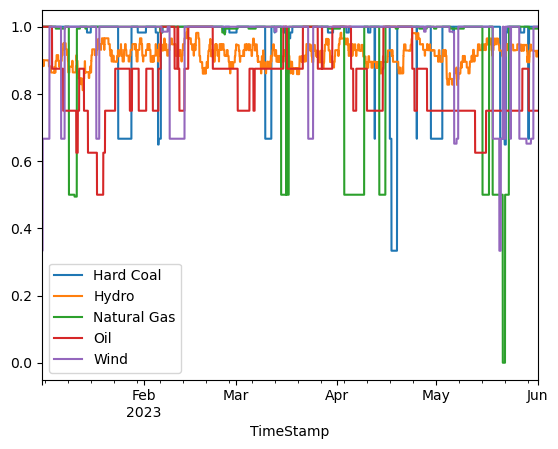

In [35]:
scenario.set_index("TimeStamp").groupby(
    [
        pd.Series(scenario.set_index("TimeStamp").columns).map(geo.set_index("projectID").Country).values,
        pd.Series(scenario.set_index("TimeStamp").columns).map(geo.set_index("projectID").Fueltype).values,
    ],
    axis=1
).mean()["Austria"].plot()

In [33]:
gen_series = pd.Series(scenario.columns[1:])

scenario.set_index("TimeStamp").groupby(
    [
        gen_series.map(geo.set_index("projectID").Country).values,
        gen_series.map(geo.set_index("projectID").Fueltype).values,
    ],
    axis=1
).mean()["Austria"]

,Hard Coal,Hydro,Natural Gas,Oil,Wind
TimeStamp,,,,,
2023-01-01 01:00:00,1.0,0.900049,1.000000,1.00,0.333333
2023-01-01 02:00:00,1.0,0.900049,1.000000,1.00,0.333333
2023-01-01 03:00:00,1.0,0.900049,1.000000,1.00,0.333333
2023-01-01 04:00:00,1.0,0.900049,1.000000,1.00,0.333333
2023-01-01 05:00:00,1.0,0.900049,1.000000,1.00,0.333333
...,...,...,...,...,...
2023-05-31 20:00:00,1.0,0.911357,0.994375,0.75,1.000000
2023-05-31 21:00:00,1.0,0.911357,0.994375,0.75,1.000000
2023-05-31 22:00:00,1.0,0.911357,0.994375,0.75,1.000000


In [ ]:
# Plot previous graph but for training dataset

In [97]:
generators = df.PowerResourceEIC.unique()
start_date = df.StartTS.min()
#end_date = df.EndTS.max()
end_date = start_date + np.timedelta64(6,"M")


In [123]:
#convert to pypsa format
df = df.sort_values(["UnitName","StartTS"])
scenarios_d = {}
for gen, gen_df in df.groupby("UnitName"):
    gen_scenario = []
    current_date = start_date
    #we assume df is sorted by startTS
    
    for index, event in gen_df.iterrows():
        if event.EndTS <= end_date:
            hours_before_event = int((event["StartTS"] - current_date) / np.timedelta64(1,"h"))
            gen_scenario += [1] * hours_before_event
            duration_event = int((event["EndTS"] - event["StartTS"]) / np.timedelta64(1,"h"))
            pu = event["p.u."]
            gen_scenario += [pu] * duration_event
            current_date = event["EndTS"]
        elif event.StartTS <= end_date:
            hours_before_event = int((event["StartTS"] - current_date) / np.timedelta64(1,"h"))
            gen_scenario += [1] * hours_before_event
            duration_event = int((end_date - event["StartTS"]) / np.timedelta64(1,"h"))
            pu = event["p.u."]
            gen_scenario += [pu] * duration_event
            current_date = end_date
            break
        else:
            break
        
    last_hours = int((end_date - current_date) / np.timedelta64(1,"h"))
    gen_scenario += [1]*last_hours
    scenarios_d[gen] = gen_scenario


min_l = 50000
for key, value in scenarios_d.items():
    if len(value) < min_l:
        min_l = len(value)
for key, value in scenarios_d.items():
    scenarios_d[key] = scenarios_d[key][:min_l]

In [124]:
timestamp = []
for h in np.arange(min_l):
    timestamp += [start_date + np.timedelta64(h,"h")]
scenarios_d["TimeStamp"] = timestamp
data_scenario = pd.DataFrame(scenarios_d)

<Axes: xlabel='TimeStamp'>

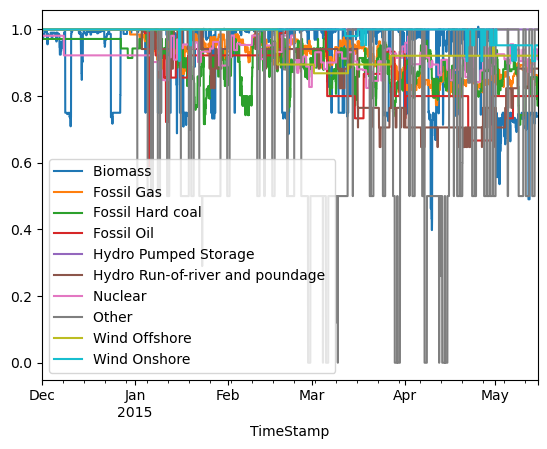

In [127]:
gen_series = pd.Series(data_scenario.set_index("TimeStamp").columns)
gen_info = df.groupby("UnitName").first().reset_index()
data_scenario.set_index("TimeStamp").groupby(
    [
        gen_series.map(gen_info.set_index("UnitName").MapCode).values,
        gen_series.map(gen_info.set_index("UnitName").ProductionType).values,
    ],
    axis=1
).mean()["GB"].plot()

In [120]:
df.columns

Index(['StartTS', 'EndTS', 'TimeZone', 'Status', 'Type', 'AreaCode',
       'AreaTypeCode', 'AreaName', 'MapCode', 'PowerResourceEIC', 'UnitName',
       'ProductionType', 'InstalledCapacity', 'AvailableCapacity', 'Version',
       'Reason', 'UpTime', 'ForcedTime', 'PlannedTime', 'RunningTime', 'p.u.'],
      dtype='object')

In [121]:
df

,StartTS,EndTS,TimeZone,Status,Type,AreaCode,AreaTypeCode,AreaName,MapCode,PowerResourceEIC,...,ProductionType,InstalledCapacity,AvailableCapacity,Version,Reason,UpTime,ForcedTime,PlannedTime,RunningTime,p.u.
266143,2014-12-01 00:00:00,2015-01-22 00:00:00,WET,Active,Planned,10YGB----------A,BZN,GB BZN,GB,48W000000HRTL-16,...,Nuclear,666.0,451.0,1,Complementary Information,NaN,NaN,1248.0,NaN,0.677177
142453,2014-12-01 00:00:00,2015-01-02 11:30:00,WET,Withdrawn,Planned,10YGB----------A,BZN,GB BZN,GB,48W00000EGGPS-2V,...,Fossil Hard coal,525.0,0.0,3,Foreseen Maintenance,NaN,NaN,779.5,NaN,0.000000
454211,2014-12-01 01:00:00,2014-12-09 00:00:00,CET,Active,Forced,10YPT-REN------W,CTA,PT CTA,PT,16WREGUA1------8,...,Hydro Run-of-river and poundage,60.0,0.0,1,Failure,NaN,191.00,NaN,NaN,0.000000
482619,2014-12-01 02:00:00,2015-02-06 00:00:00,CET,Active,Forced,10YPL-AREA-----S,CTA,PL CTA,PL,19W000000000184V,...,Fossil Hard coal,128.0,0.0,2,Failure,NaN,1606.00,NaN,NaN,0.000000
97966,2014-12-01 02:51:00,2014-12-01 03:48:00,WET,Active,Forced,10YGB----------A,CTA,UK(National Grid) CTA,GB,48W00000DRAXX-2C,...,Biomass,645.0,615.0,1,Failure,NaN,0.95,NaN,NaN,0.953488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355518,2030-01-11 23:00:00,2030-01-14 07:00:00,WET,Active,Planned,10YGB----------A,CTA,UK(National Grid) CTA,GB,48W000000LBAR-1Y,...,Fossil Gas,735.0,0.0,2,Foreseen Maintenance,91 days 00:00:00,NaN,56.0,2128.0,0.000000
355519,2030-03-08 23:00:00,2030-03-11 07:00:00,WET,Active,Planned,10YGB----------A,BZN,GB BZN,GB,48W000000LBAR-1Y,...,Fossil Gas,735.0,0.0,2,Foreseen Maintenance,56 days 00:00:00,NaN,56.0,1288.0,0.000000
355520,2030-05-10 23:00:00,2030-06-14 07:00:00,WET,Active,Planned,10YGB----------A,CTA,UK(National Grid) CTA,GB,48W000000LBAR-1Y,...,Fossil Gas,735.0,0.0,2,Foreseen Maintenance,63 days 00:00:00,NaN,824.0,1456.0,0.000000
306882,2030-06-30 08:00:00,2030-06-30 09:30:00,CET,Active,Planned,10Y1001A1001A44P,BZN,SE1 BZN,SE,46WGU0000000028T,...,Hydro Water Reservoir,440.0,0.0,1,Foreseen Maintenance,2869 days 01:00:00,NaN,1.5,68752.0,0.000000


In [75]:
df["UnitName"]

0         ABO¿O 1
1         ABO¿O 1
2         ABO¿O 1
4         ABO¿O 1
6         ABO¿O 1
           ...   
573766      ÚJ_ST
573767      ÚJ_ST
573769      ÚJ_ST
573771      ÚJ_ST
573772      ÚJ_ST
Name: UnitName, Length: 454256, dtype: object

NameError: name 'pu' is not defined